# Assignment 1: Building Neural Networks for Image Classification

## Overview
Welcome back to Assignment 1! In this assignment, you'll dive into the fascinating realm of deep learning by building and training neural networks for image classification and object detection tasks using the PyTorch framework. You'll work with two popular datasets: MNIST for image classification and CIFAR-100 for object detection. Throughout the assignment, you'll also fine-tune your models to achieve optimal results.

## Part 3: Fine Tuning Model to Achieve Best Accuracy
In the final section of the assignment, you'll take your models to the next level by fine-tuning them and achieving benchmark performance. You'll experiment with different architectures, hyperparameters, learning rates, and optimization techniques to achieve the best possible accuracy for object classification (CIFAR-100). Your journey will involve analyzing the impact of these changes on the models' accuracy and convergence. Feel free to write your own modules, and make changes to starter code to achieve highest possible accuracy. Results are expected to be submitted in the same format as previous sections however.

For your reference, here are the benchmark standards achieved by state of the art classifiers:
https://paperswithcode.com/sota/image-classification-on-cifar-100

Note: You can implement your own Fine tuned CNN, AlexNet, ResNET, etc architectures discussed in class. However, No transfer learning or pretrained models allowed. If, you were able to achieve 60\% test accuracy with any of your previous implementations, submit same model and explain key optimizations and fine-tunings made.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Specify font family to avoid font warnings on Colab
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Define hyperparameters
owner ='chuangm'
batch_size = 256
learning_rate = 0.001
epochs = 20
eval_every=1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

transform_train = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

transform_test = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 169001437/169001437 [00:02<00:00, 81938764.61it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class BasicBlock(nn.Module):
    def __init__(self,inplanes,planes,stride=1,downsample=None):
      super(BasicBlock, self).__init__()
      self.cnn_part = nn.Sequential(
        # do two cnn with kernel size:3
        # need padding here for matching
        # bias?
        nn.Conv2d(inplanes,planes,kernel_size=3,stride=stride,padding=1,bias=False),
        nn.BatchNorm2d(planes),
        nn.ReLU(inplace=True),
        nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(planes))
      self.downsample = downsample
      self.relu = nn.ReLU(inplace=True)
      self.stride = stride

    def forward(self, x):
      # identity
      identity = x
      out = self.cnn_part(x)
      # check
      if self.downsample is not None:
        identity = self.downsample(x)

      out += identity
      out = self.relu(out)

      return out


In [6]:
# TODO: Define your CNNModel class
class ImprovedCNN_Alexnet_Resnet(nn.Module):
    def __init__(self):
        # based on resnet18
        super(ImprovedCNN_Alexnet_Resnet, self).__init__()
        self.inplanes=64
        self.dilation= 1
        self.cnn_part= nn.Sequential(
          nn.Conv2d(3, 64, 3, stride=1,padding=1,bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.layer1=self.make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(BasicBlock, 128, 3, stride=2)
        self.layer3 = self.make_layer(BasicBlock, 256, 3, stride=2)
        self.layer4 = self.make_layer(BasicBlock, 512, 1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 100)

    def make_layer(self,block,planes,blocks,stride=1)-> nn.Sequential:
        # norm_layer = self._norm_layer
        downsample = None
        if stride!= 1 or self.inplanes != planes:
          downsample = nn.Sequential(
              # conv1X1
              nn.Conv2d(self.inplanes,planes,kernel_size =1,stride = stride,bias=False),
              nn.BatchNorm2d(planes))
        layers = []
        layers.append(block(self.inplanes, planes, stride,downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes,planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.cnn_part(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x


In [7]:
cnn_model = ImprovedCNN_Alexnet_Resnet().to(device)


# Define loss function and optimizer
cnn_optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(cnn_optimizer, T_max=100)
criterion = torch.nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

In [8]:
def init_weights(layer):
    if isinstance(layer, torch.nn.Linear):
        nn.init.kaiming_normal_(layer.weight)

# Apply Xavier initialization to all linear layers in the model
cnn_model.apply(init_weights)

ImprovedCNN_Alexnet_Resnet(
  (cnn_part): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (cnn_part): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (cnn_part): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [11]:
# Training loop
checkpoint_path = "/content/drive/MyDrive/Colab_Checkpoints/checkpoint_patterm_resnet.pt"


# checkpoint = torch.load(checkpoint_path)
# cnn_model.load_state_dict(checkpoint['model_dict'])
# cnn_optimizer.load_state_dict(checkpoint['optimizer_dict'])

def train(model, optimizer, train_dataloader, test_dataloader, epochs):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_dataloader:
             # TODO: Implement the following steps within this loop
             # 1. Zero the gradients
             # 2. Perform a forward pass through the model to get predictions
             # 3. Calculate the loss between predictions and labels
             # 4. Perform a backward pass to compute gradients
             # 5. Update the model's parameters using the optimizer
             # 6. Accumulate the loss in a variable
              # TODO: Implement the following steps within this loop
            # 1. Zero the gradients
            optimizer.zero_grad()
            # 2. Perform a forward pass through the model to get predictions
            # 3. Calculate the loss between predictions and labels
            # 4. Perform a backward pass to compute gradients
            # 5. Update the model's parameters using the optimizer
            # 6. Accumulate the loss in a variable
            # 7. Save checkpoints if needed
            inputs      = inputs.to(device)
            labels    = labels.to(device)
            # TODO Call model and get ouptuts
            with torch.cuda.amp.autocast():
              logits  = model(inputs)
            # TODO: Calculate the loss using loss function
            # TODO:Replace with your custom loss calculation
            # uncomment after defining below correctly
              loss    = criterion(logits, labels)
            # call backward on loss
            # loss.backward()
            # # TODO Add optimiser  step
            # optimizer.step()
            scaler.scale(loss).backward() # This is a replacement for loss.backward()
            scaler.step(optimizer) # This is a replacement for optimizer.step()
            scaler.update()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_loss)
        # After the loop, calculate the average training loss and append it to the train_losses list -TODO

        # Evaluate on the test set
        model.eval()
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_loss)

        scheduler.step(test_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}")


        checkpoint = {
          'model_dict':model.state_dict(),
          'optimizer_dict':optimizer.state_dict(),
        }
        torch.save(checkpoint, checkpoint_path)

    return train_losses, test_losses

# Train the CNN model and record losses
# Define Hyperparameters, if needed
cnn_train_losses, cnn_test_losses = train(cnn_model,cnn_optimizer,trainloader,testloader, epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 - Train Loss: 0.6171858605681634, Test Loss: 1.7128946989774705
Epoch 2/20 - Train Loss: 0.4446941833106839, Test Loss: 1.8207163631916046
Epoch 3/20 - Train Loss: 0.41447800184999195, Test Loss: 1.7561959624290466
Epoch 4/20 - Train Loss: 0.3758825647587679, Test Loss: 1.796661016345024
Epoch 5/20 - Train Loss: 0.34077852941593345, Test Loss: 1.8433927118778228
Epoch 6/20 - Train Loss: 0.31109852070102884, Test Loss: 1.8756920397281647
Epoch 7/20 - Train Loss: 0.2914641181729278, Test Loss: 1.8505940943956376
Epoch 8/20 - Train Loss: 0.2813247912848482, Test Loss: 1.97678442299366
Epoch 9/20 - Train Loss: 0.2618456809040235, Test Loss: 1.9005188703536988
Epoch 10/20 - Train Loss: 0.24873925988771478, Test Loss: 1.9716935843229293
Epoch 11/20 - Train Loss: 0.22886295456971442, Test Loss: 2.0791012167930605
Epoch 12/20 - Train Loss: 0.2281324488624018, Test Loss: 2.1012216567993165
Epoch 13/20 - Train Loss: 0.2109405563345977, Test Loss: 2.086405870318413
Epoch 14/20 - Train 

# Visualize Final Results: Best Model - CIFAR 100

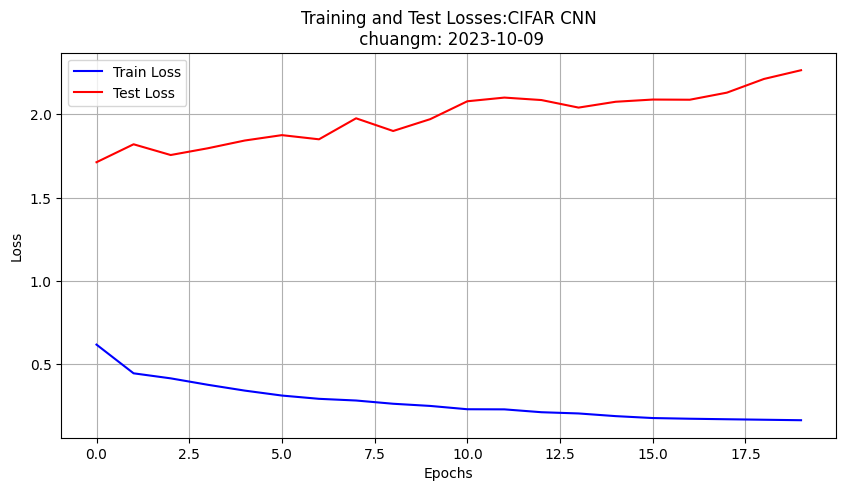

In [12]:
# Plot train and test losses
import datetime

current_datetime = datetime.datetime.now()
timestamp_str = current_datetime.strftime('%Y-%m-%d')

eval_every = 1

# Plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(cnn_train_losses[::eval_every], label='Train Loss', color='blue')
plt.plot(cnn_test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Test Losses:CIFAR CNN\n {owner}: {timestamp_str}')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Final Evaluation on Test Dataset for accuracy
def evaluate(model, dataloader):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode (e.g., disables dropout)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

# Evaluate the model
cnn_accuracy = evaluate(cnn_model, testloader)

print("Final Fine Tuned Model Test Accuracy:", cnn_accuracy)

Final Fine Tuned Model Test Accuracy: 61.53999999999999


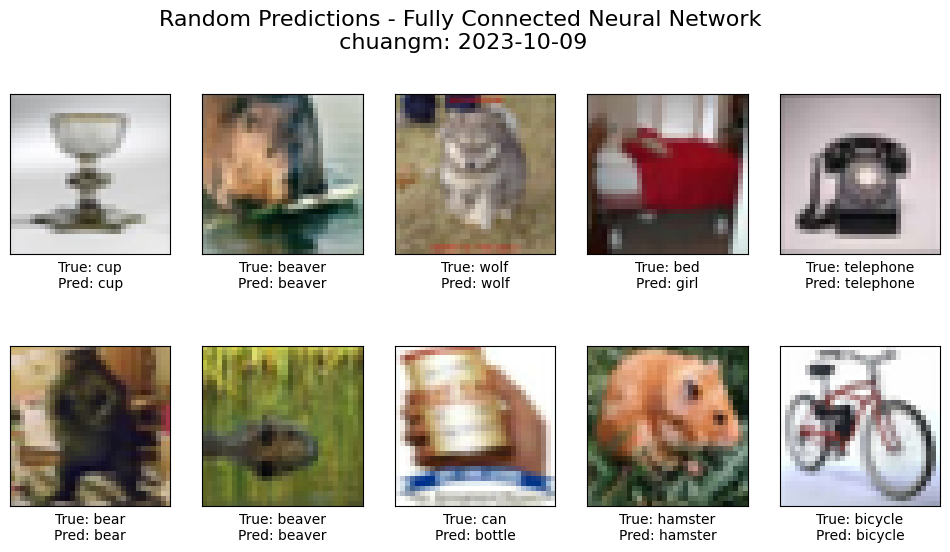

In [15]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch

current_datetime = datetime.datetime.now()
timestamp_str = current_datetime.strftime('%Y-%m-%d')

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualize predictions
class_to_label = testset.classes

plt.figure(figsize=(12, 6))
random_inds = np.random.choice(len(testset), 10)

for i, image_idx in enumerate(random_inds):
    test_image, test_label = testset[image_idx]
    test_image = test_image.unsqueeze(0).to(device)  # Move input data to the selected device

    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((test_image.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2)  # Move image to CPU for plotting

    with torch.no_grad():
        output = cnn_model(test_image)
        predicted_label_idx = torch.argmax(output).item()

    true_label = class_to_label[test_label]
    predicted_label = class_to_label[predicted_label_idx]

    plt.xlabel(f"True: {true_label}\nPred: {predicted_label}")

plt.suptitle(f'Random Predictions - Fully Connected Neural Network\n {owner}: {timestamp_str}', fontsize=16)
plt.show()